# Simulation of Failed Resection Motifs

Simulate a failed localization in the following situations:

1. EZ on the other side of the brain (contralateral hemisphere)
2. EZ hyper-connected to the regions that are being observed

In [1]:
import numpy as np
import pandas as pd
import mne
from pprint import pprint

import os
import json
import os.path as op
from pathlib import Path
import collections

from sklearn.datasets import make_spd_matrix
from mne.io import RawArray
from mne import create_info
from mne_bids import BIDSPath, get_entity_vals, read_raw_bids
import mne
mne.utils.use_log_level('error')
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import scipy

import dabest
import pydmd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score

from mne_features.univariate import compute_spect_slope
from mne_features.utils import power_spectrum

from eztrack.io.base import _add_desc_to_bids_fname, concatenate_derivs
from eztrack.io import read_derivative_npy, create_deriv_info, DerivativeArray
from eztrack.fragility import (lds_raw_fragility, DiscreteLinearSystem, 
                               SystemIDModel, StructuredPerturbationModel)
from eztrack.viz import _load_turbo, generate_heatmap
from eztrack.posthoc.hypo import compute_null

import sys
sys.path.append('../../')
from sickkids.dmd.dmd import rescale_modes
from sickkids.posthoc.spectral import compute_significant_freqs, compute_bootstrap_lr
from sickkids.tvb.simulation import load_subject_connectivity, setup_simulation, resect_regions
from sickkids.tvb.utils import read_surf


_load_turbo()

# %matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 2

2020-12-18 20:24:40,333 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO


In [609]:
from tvb.simulator.models.epileptor import Epileptor
from tvb.simulator.models.epileptor_rs import EpileptorRestingState
from tvb.simulator.lab import cortex, local_connectivity

# Load Data

In [2]:
np.random.seed(12345)

In [3]:
# paths to data
root = Path('/Users/adam2392/Dropbox/resection_tvb/')
source_path = root / 'sourcedata'
experimental_condition = 'epilepsy'
subject = 'id008_gc'
# subject = 'id013_pg'

subj_path = source_path / experimental_condition / subject
source_file = subj_path / 'tvb' / 'connectivity.zip'

In [4]:
output_path = Path('/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb')
output_path.mkdir(exist_ok=True, parents=True)

In [5]:
# first load in the channel's xyz coordinates
ch_xyz_fpath = subj_path / 'elec' / 'seeg.txt'

seeg_pd = pd.read_csv(
    ch_xyz_fpath, names=['x', 'y', 'z'], delim_whitespace=True)

ch_names = seeg_pd.index.values
ch_xyz = seeg_pd.to_numpy()
ch_pos = seeg_pd.T.to_dict(orient='list')

In [7]:
# got all the channels!
print(ch_names)

['R1' 'R2' 'R3' 'R4' 'R5' 'R6' 'R7' 'R8' 'R9' 'R10' 'R11' 'CR1' 'CR2'
 'CR3' 'CR4' 'CR5' 'CR6' 'CR7' 'CR8' 'CR9' 'CR10' 'CR11' 'FD1' 'FD2' 'FD3'
 'FD4' 'FD5' 'FD6' 'FD7' 'FD8' 'FD9' 'FD10' 'FD11' 'CC1' 'CC2' 'CC3' 'CC4'
 'CC5' 'CC6' 'CC7' 'CC8' 'CC9' 'CC10' 'CC11' 'TP1' 'TP2' 'TP3' 'TP4' 'TP5'
 'TP6' 'A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' 'A9' 'A10' 'A11' 'A12'
 'A13' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B8' 'B9' 'B10' 'B11' 'B12'
 'B13' 'GPH1' 'GPH2' 'GPH3' 'GPH4' 'GPH5' 'GPH6' 'GPH7' 'GPH8' 'GPH9'
 'GPH10' 'GPH11' 'GPH12' 'T1' 'T2' 'T3' 'T4' 'OR1' 'OR2' 'OR3' 'OR4' 'OR5'
 'OR6' 'OR7' 'OR8' 'OR9' 'OR10' 'OR11']


In [8]:
gain_inv_fname = subj_path / 'elec' / 'gain_inv-square.txt'

print(gain_inv_fname)

/Users/adam2392/Dropbox/resection_tvb/sourcedata/epilepsy/id008_gc/elec/gain_inv-square.txt


In [607]:
if subject == 'id013_pg':
    ez_label = ['ctx-rh-fusiform', 
#                 'Right-Hippocampus', 'Right-Amygdala'
               ]
    pz_label = ['Right-Hippocampus', 'Right-Amygdala', 
#                 'ctx-rh-middltemporal', 
                'ctx-rh-inferiortemporal',
#                 'ctx-rh-entorhinal'
               ] 
elif subject == 'id008_gc':
    ez_label = ['Right-Amygdala', 'Right-Hippocampus', 
#                                'ctx-rh-medialorbitofrontal',
               ]
    pz_label = [
#         'ctx-rh-superiortemporal', 
#                 'ctx-rh-middletemporal', 
                'ctx-rh-inferiortemporal', 
                'ctx-rh-temporalpole',
#                 'ctx-rh-lateralorbitofrontal'
               ]
else:
    ez_label = None
    pz_label = None

In [608]:
# read in the ez hypothesis regions
with open(subj_path / 'tvb' / 'ez_hypothesis.txt', 'r') as fin:
    ez_hypo = pd.read_csv(fin, delimiter='\n').to_numpy().squeeze()
print(ez_hypo)
ezhypo_inds = ez_hypo[np.argwhere(ez_hypo == 1)]

# get the hypothesized EZ and PZ
ezhypo_inds = np.where(np.in1d(conn.region_labels, ez_label))
ez_regions = conn.region_labels[ezhypo_inds]

pzhypo_inds = np.where(np.in1d(conn.region_labels, pz_label))
pz_regions = conn.region_labels[pzhypo_inds]

print(ez_regions, pz_regions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0]
['Right-Hippocampus' 'Right-Amygdala'] ['ctx-rh-inferiortemporal' 'ctx-rh-temporalpole']


In [600]:
conn = load_subject_connectivity(
    source_file=str(source_file), condspeed=3.
)

In [601]:
# show the summary for this subject
print(conn)

Connectivity (
  Number of connections ........................ 0
  Number of regions ............................ 0
  Undirected ................................... False
  areas [min, median, max] ..................... [299.64, 1983.88, 13628.8]
  areas dtype .................................. float64
  areas shape .................................. (84,)
  tract_lengths (connections) [min, median, max]  [13.338, 118.306, 196.851]
  tract_lengths [min, median, max] ............. [0, 117.422, 196.851]
  tract_lengths-non-zero [min, median, max] .... [13.338, 118.306, 196.851]
  weights [min, median, max] ................... [0, 0.00026989, 1]
  weights dtype ................................ float64
  weights shape ................................ (84, 84)
  weights-non-zero [min, median, max] .......... [3.37363e-06, 0.000293505, 1]
)


# Find Stable Initial Conditions

In [610]:
sim = setup_simulation(
    conn, ch_xyz, gain_fname=str(gain_inv_fname),
    ezind=ezhypo_inds,
    pzind=pzhypo_inds,
    seeg_fname=ch_xyz_fpath,
    variables_of_interest=['x1', 'y1', 'z', 'x2', 'y2', 'g', 'x2 - x1'],
    r=0.00035 / 10, tt=0.75
)

[<tvb.simulator.monitors.TemporalAverage object at 0x13b5ed2e0>, <tvb.simulator.monitors.iEEG object at 0x13895a670>]


In [611]:
(times, epilepts), (_, seegts) = sim.run(simulation_length=10000)

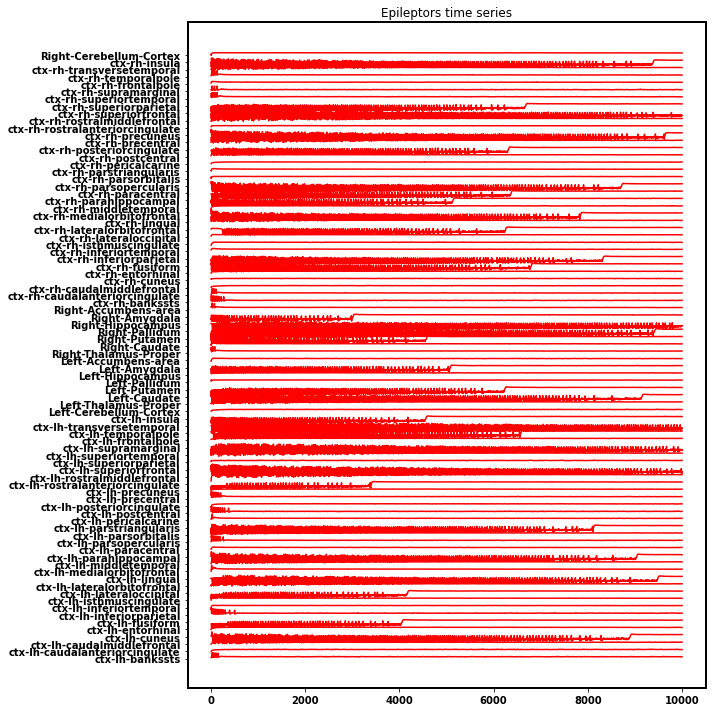

In [612]:
#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(times[:], epilepts[:, -1, :, 0] / (np.max(epilepts[:, -1, :, 0].max(axis=0))) + np.r_[:len(conn.region_labels)], 'r')
plt.title("Epileptors time series")
plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()

In [613]:
# note that there are now 7 state variables
# the first 6 are part of the Epileptor fast/slow/veryslow subsystems 
# the last 1 is the actual time series that is projected to the sEEG electrode locations
print(epilepts.shape)

(10000, 7, 84, 1)


In [614]:
# we store the initial conditions as a 6x1 array
initial_conditions = epilepts[-1, :-1, :, :][np.newaxis, ...]

# re-run simulation and check that initial conditions worked
sim = setup_simulation(
    conn, ch_xyz, gain_fname=str(gain_inv_fname),
    ezind=ezhypo_inds, pzind=pzhypo_inds,
    seeg_fname=ch_xyz_fpath,
    variables_of_interest=['x1', 'y1', 'z', 'x2', 'y2', 'g', 'x2 - x1'],
    r=0.00035 / 10, tt=0.75, initial_conditions=initial_conditions,
#     resected_chs=resected_chs
)

(times, epilepts), (_, seegts) = sim.run(simulation_length=15000)

[<tvb.simulator.monitors.TemporalAverage object at 0x1387d5c10>, <tvb.simulator.monitors.iEEG object at 0x1386c5d30>]


In [615]:
# make sure subject doesn't have '_' character
subject = subject.replace('_', '')
print(subject)

# create a file path to save initial conditions to
bids_path = BIDSPath(subject=subject, session='preresection', 
                     task='initialconditionswithfrontal', 
                     suffix='epileptor',
                     extension='.npy', check=False)
initial_cond_fpath = output_path / bids_path.basename

id008gc


In [619]:
# save initial conditions into a numpy array
np.save(initial_cond_fpath, initial_conditions)
print(f'Saved initial conditions to: {initial_cond_fpath}')

Saved initial conditions to: /Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb/sub-id008gc_ses-preresection_task-initialconditionswithfrontal_epileptor.npy


In [617]:
initial_conditions = epilepts[2100, :-1, ...][np.newaxis, ...]
print(initial_conditions.shape)

(1, 6, 84, 1)


In [620]:
initial_conditions = np.load(initial_cond_fpath)
print(initial_conditions.shape)

(1, 6, 84, 1)


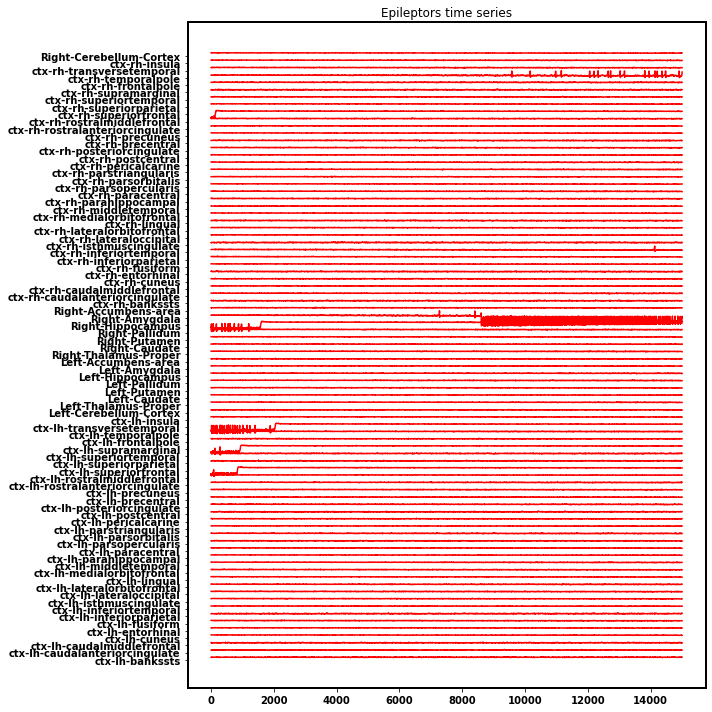

In [616]:
#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(times[:], epilepts[:, -1, :, 0] / (np.max(epilepts[:, -1, :, 0].max(axis=0))) + np.r_[:len(conn.region_labels)], 'r')
plt.title("Epileptors time series")
plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()

# Setup Final Simulation Object

In [621]:
print(ezhypo_inds, pzhypo_inds)

(array([46, 47]),) (array([56, 80]),)


In [622]:
sim = setup_simulation(
    conn, ch_xyz, gain_fname=str(gain_inv_fname),
    ezind=ezhypo_inds, pzind=pzhypo_inds,
    seeg_fname=ch_xyz_fpath,
    initial_conditions=initial_conditions,
#     x0norm=-2.40, 
    r=0.00035 / 10, tt=0.75,
#     pzind=pzhypo_inds,
)

[<tvb.simulator.monitors.TemporalAverage object at 0x1385b1670>, <tvb.simulator.monitors.iEEG object at 0x1392ae670>]


In [623]:
print(sim)

Simulator (
  Type ................................ Simulator
  conduction_speed .................... 3.0
  connectivity ........................ Connectivity gid: 41ac11db-a64f-4a86-a271-1325d689ee9f
  coupling ............................ Difference gid: 902a6d61-6745-47f9-93b2-ee08ade998c3
  gid ................................. UUID('d0f3be0c-5e8f-4318-abb2-b63769e2ddbe')
  initial_conditions [min, median, max]  [-18.7724, -0.488896, 4.05029]
  initial_conditions dtype ............ float64
  initial_conditions shape ............ (1, 6, 84, 1)
  integrator .......................... HeunStochastic gid: afa6723e-f808-4449-b837-c45ae4f99375
  model ............................... Epileptor gid: 186d783b-7ae2-4243-8bf2-4463deac2741
  monitors ............................ [<tvb.simulator.monitors.TemporalAverage object at 0x1385b1670>, <tvb.simulator.monitors.iEEG object at 0x1392ae670>]
  simulation_length ................... 1000.0
  stimulus ............................ None
  surfac

# Run Simulation

In [624]:
sim_length = 30000
(times, epilepts), (_, seegts) = sim.run(
        simulation_length=sim_length)

In [625]:
seeg = seegts.copy()
tavg = epilepts.copy()

In [626]:
# Normalize the time series to have nice plots
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
seeg /= (np.max(seeg,0) - np.min(seeg, 0))
seeg -= np.mean(seeg, 0)

In [627]:
print(len(conn.region_labels))
print(epilepts.shape)
print(epilepts[:, 0, :, 0].max(axis=0).shape)

84
(30000, 2, 84, 1)
(84,)


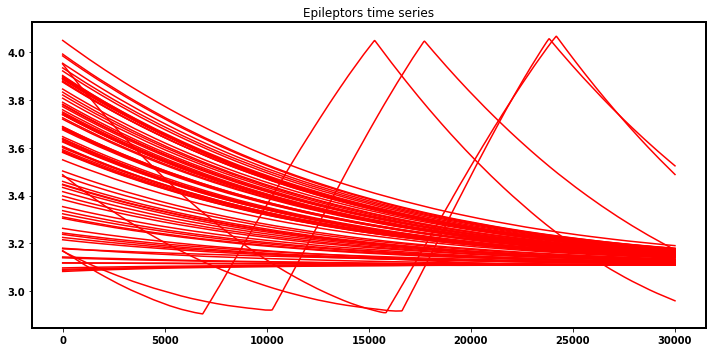

In [628]:
#Plot raw time series
plt.figure(figsize=(10,5))
plt.plot(times[:], epilepts[:, 0, :, 0]
#          + np.r_[:len(conn.region_labels)]
         , 'r')
plt.title("Epileptors time series")
# plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()



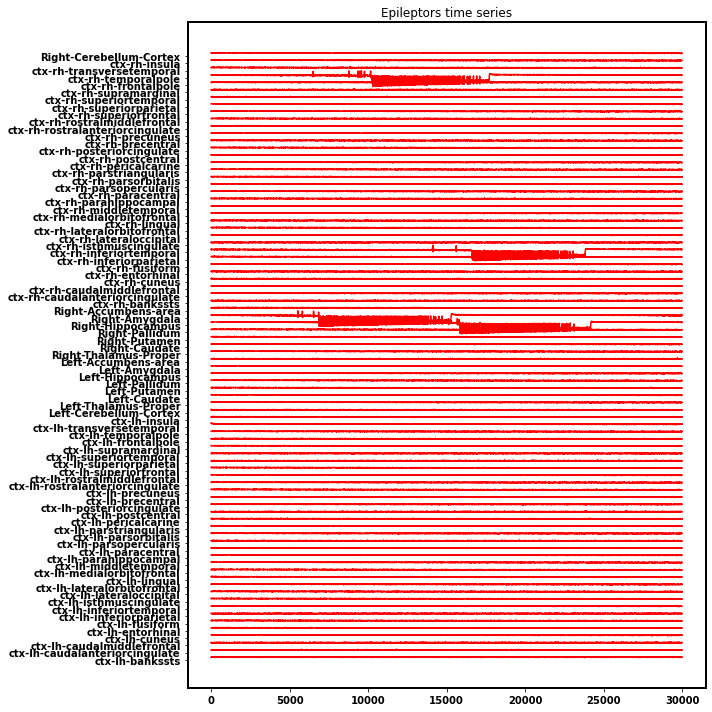

In [629]:
#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(times[:], epilepts[:, 1, :, 0] / (np.max(epilepts[:, 1, :, 0].max(axis=0))) + np.r_[:len(conn.region_labels)], 'r')
plt.title("Epileptors time series")
plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()